In [1]:
import os
os.chdir("../")
os.environ["OMP_NUM_THREADS"] = "11"

In [2]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
COLORS = list(TABLEAU_COLORS.values())

In [3]:
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, accuracy_score

In [4]:
from scripts.data.load import load_cora

In [5]:
ids, data, target, edges = load_cora()

In [6]:
def visualize_encoding_spread(X, Y):
    pca = PCA(n_components=2)
    x,y = pca.fit_transform(X).T
    
    label_idxs = {l:i for i,l in enumerate(set(Y))}
    label_idxs = [label_idxs[l] for l in Y]
    c = [COLORS[i%len(COLORS)] for i in label_idxs]
    plt.scatter(x,y,c=c,marker=".")

In [7]:
def match_labels(y_pred, y_actual):
    cls_map = defaultdict(lambda: defaultdict(int))
    for a, b in zip(y_pred, y_actual):
        cls_map[a][b] += 1
    
    for _cls, counts in cls_map.items():
        best_label = sorted(counts.items(), key=lambda x:x[1], reverse=True)[0][0]
        cls_map[_cls] = best_label
    
    return [cls_map[y] for y in y_pred]

In [8]:
def evaluate(model, X):
    y_pred = model.fit_predict(X)
    acc = round(accuracy_score(target, match_labels(y_pred, target)), 2)
    nmi = round(normalized_mutual_info_score(target, y_pred),2)
    ars = round(adjusted_rand_score(target, y_pred),2)
    print(f"acc: {acc}  nmi: {nmi} ars: {ars}")

In [9]:
def normalize(X):
    return (X.T /((X**2).sum(axis=1)**0.5)).T

In [496]:
def step(x, other_ends, t, spring_constants, rest_lengths=1, initial_velocity=0, mass=1, max_force=5):
    delta = other_ends-x
    dist = (delta**2).sum(axis=1)
    unit = (delta.T/dist).T
    dist_rest = dist - rest_lengths
    delta_rest = (unit.T*dist_rest).T
    delta_rest[~np.isfinite(delta_rest)]=0
    f = np.dot(spring_constants, delta_rest)/len(other_ends)
    # f /= abs(f).max()
    dx = ((f/mass)*t**2)/2 #+ initial_velocity*t
    x += dx

In [625]:
arr = np.array([[0,0],[0,.1],[.1,-.1],[.2,.5]], dtype=np.float32)

C:\Users\stans\AppData\Local\Temp\ipykernel_15768\55850255.py:4: RuntimeWarning: invalid value encountered in divide
  unit = (delta.T/dist).T


(-1.0, 3.0)

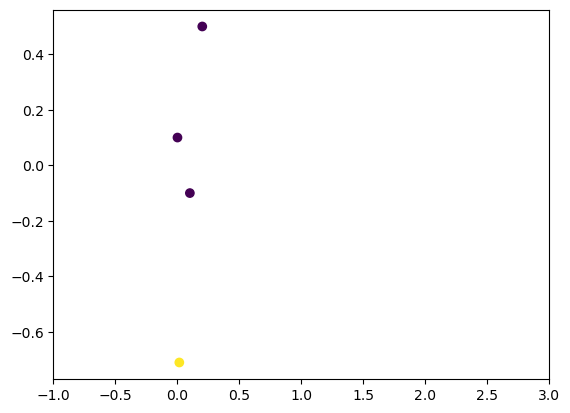

In [656]:
step(arr[0],arr,0.5,np.array([0,1,0,1]))
plt.scatter(arr[:,0], arr[:,1], c=[1,0,0,0])
plt.xlim(-1,3)

In [555]:
class MultiForce:
    def __init__(self, learning_rate=0.1, max_iter=10):
        self.lr = learning_rate
        self.max_iter = max_iter
    
    def fit_transform(self, *affinities, position=None, verbose=1):
        N = len(affinities[0])
        position = position if position is not None else np.random.random((N,32)).astype(np.float32)
        aggregate_motion = np.ones(position.shape, dtype=np.float32)
        for a in affinities:
            for i in range(N):
                a[i,i] = 0
        i=0
        while i < self.max_iter:
            i += 1
            for a in affinities:
                for j, x in enumerate(position):
                    step(x, position, t=self.lr, spring_constants=a[j])
        return position

In [311]:
def affinity_matrix(x):
    N,M = x.shape
    res = np.zeros((N,N), dtype=x.dtype)
    for i in range(N-1):
        a = x[i]
        b = x[i+1:]
        d = ((b-a)**2).sum(axis=1)
        res[i,i+1:] = d
    res += res.T
    res = -res+(res.max()/2)
    return res/abs(res).max()

In [312]:
id_idx_map = {_id: i for i, _id in enumerate(ids)}
references = {_id: [u for u, v in edges if v == _id] for _id in ids}

In [313]:
adjacency = np.zeros((len(ids),len(ids)))
# 1st order
for u,v in edges:
    u_idx = id_idx_map[u]
    v_idx = id_idx_map[v]
    adjacency[v_idx,u_idx] = 1

# 2nd order
for i, refs in enumerate(adjacency):
    r = adjacency[refs==1,:].sum(axis=0)
    k = 0.5**r[r>0]
    adjacency[i, r>0] += -k+1
adjacency[adjacency==0]=-1

In [314]:
pca = PCA(n_components=32)

In [671]:
sim_words = affinity_matrix(normalize(pca.fit_transform(data)))
sim_refs = affinity_matrix(normalize(pca.fit_transform(adjacency)))
refs = normalize(adjacency)
refs[np.isnan(refs)]=1

In [672]:
sim_words += sim_words.min()+0.1
sim_refs += sim_refs.min()+0.1
refs += refs.min()+0.1

In [331]:
mf = MultiForce(learning_rate=.001, max_iter=1)

In [332]:
position = normalize(pca.fit_transform(adjacency))

In [343]:
position = mf.fit_transform(sim_words, position=position)

C:\Users\stans\AppData\Local\Temp\ipykernel_15768\1827690828.py:4: RuntimeWarning: invalid value encountered in divide
  unit = (delta.T/dist).T


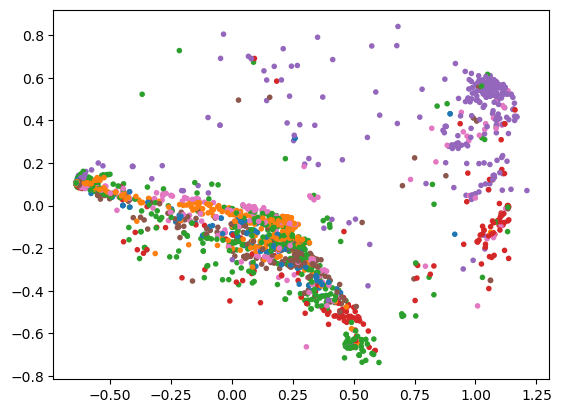

In [344]:
visualize_encoding_spread(position, target)

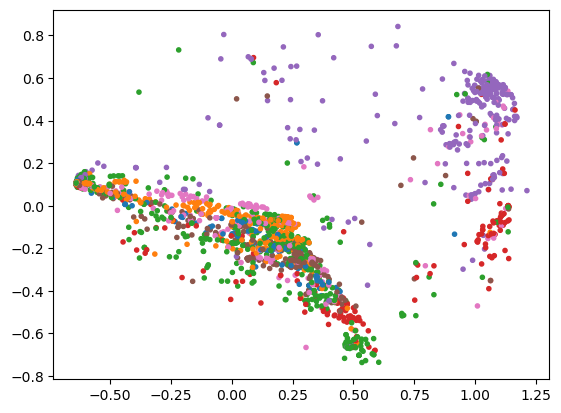

In [286]:
visualize_encoding_spread(position, target)

C:\Users\stans\AppData\Local\Temp\ipykernel_15768\181761133.py:5: RuntimeWarning: invalid value encountered in divide
  unit = (delta.T/dist).T


acc: 0.3  nmi: 0.02 ars: 0.01


C:\Users\stans\AppData\Local\Temp\ipykernel_15768\181761133.py:5: RuntimeWarning: invalid value encountered in divide
  unit = (delta.T/dist).T


acc: 0.3  nmi: 0.01 ars: 0.0


C:\Users\stans\AppData\Local\Temp\ipykernel_15768\181761133.py:5: RuntimeWarning: invalid value encountered in divide
  unit = (delta.T/dist).T


acc: 0.3  nmi: 0.01 ars: 0.0


C:\Users\stans\AppData\Local\Temp\ipykernel_15768\181761133.py:5: RuntimeWarning: invalid value encountered in divide
  unit = (delta.T/dist).T


acc: 0.3  nmi: 0.01 ars: 0.0


C:\Users\stans\AppData\Local\Temp\ipykernel_15768\181761133.py:5: RuntimeWarning: invalid value encountered in divide
  unit = (delta.T/dist).T


acc: 0.3  nmi: 0.01 ars: 0.0


C:\Users\stans\AppData\Local\Temp\ipykernel_15768\181761133.py:5: RuntimeWarning: invalid value encountered in divide
  unit = (delta.T/dist).T


acc: 0.3  nmi: 0.0 ars: -0.0


C:\Users\stans\AppData\Local\Temp\ipykernel_15768\181761133.py:5: RuntimeWarning: invalid value encountered in divide
  unit = (delta.T/dist).T


acc: 0.3  nmi: 0.0 ars: -0.0


C:\Users\stans\AppData\Local\Temp\ipykernel_15768\181761133.py:5: RuntimeWarning: invalid value encountered in divide
  unit = (delta.T/dist).T


acc: 0.3  nmi: 0.0 ars: -0.0


C:\Users\stans\AppData\Local\Temp\ipykernel_15768\181761133.py:5: RuntimeWarning: invalid value encountered in divide
  unit = (delta.T/dist).T


acc: 0.3  nmi: 0.01 ars: -0.0


C:\Users\stans\AppData\Local\Temp\ipykernel_15768\181761133.py:5: RuntimeWarning: invalid value encountered in divide
  unit = (delta.T/dist).T


acc: 0.3  nmi: 0.01 ars: -0.0


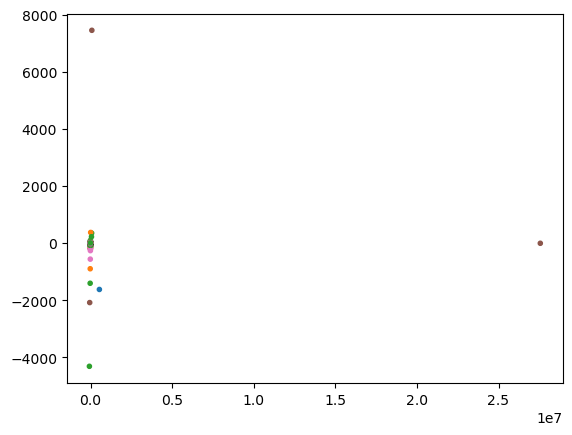

In [283]:
model = KMeans(n_clusters=7)
for i in range(10):
    position = mf.fit_transform(sim_words, sim_refs, refs, position=position)
    evaluate(model, normalize(pca.fit_transform(position)))
visualize_encoding_spread(position, target)

In [723]:
sim_words = (-sim_words + sim_words.max())*10
sim_refs = (-sim_refs + sim_refs.max())*10

In [815]:
def step(x, other_ends, t, spring_constants, rest_lengths=1, initial_velocity=0, mass=1, max_forces=5):
    delta = other_ends-x
    dist = (delta**2).sum(axis=1)
    dist[dist<0.1] = 0.1
    idxs = np.argsort(dist*spring_constants)[:max_forces]
    dist = dist[idxs] 
    unit = (delta[idxs].T/dist).T
    dist_rest = dist - rest_lengths[idxs]
    delta_rest = (unit.T*dist_rest).T
    f = np.dot(spring_constants[idxs], delta_rest)/len(other_ends[idxs])
    x += ((f/mass)*t**2)/2 #+ initial_velocity*t 

In [834]:
N=1000
arr = np.random.random((N,8)).astype(np.float32)
A = (sim_words[:N,:N],)# sim_refs[:N,:N]
K = -1*(np.identity(N))+1

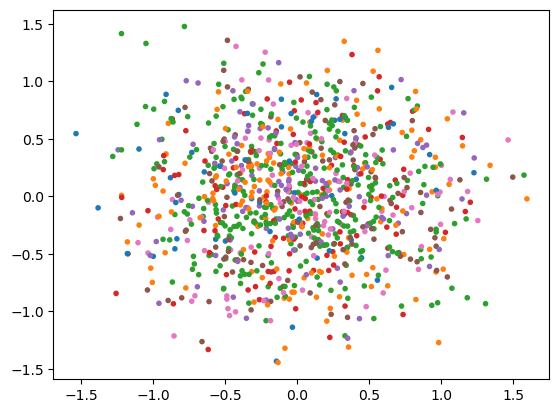

In [835]:
# plt.scatter(arr[:,0], arr[:,1], c=c)
for s in range(100):
    for aff in A:
        for i, x in enumerate(arr):
            step(x,arr,.5,aff[i],K[i])
    # c = [1 if i==j else 0 for j in range(len(arr))]
visualize_encoding_spread(arr, target[:N])
# plt.xlim(-1,1.5)

In [374]:
arr[:,0]

array([0.10743283, 0.21005037, 0.6924777 , 0.95154935, 0.16686505,
       0.8752976 , 0.04692294, 0.9464684 , 0.1608211 , 0.8270807 ,
       0.98753136, 0.4330947 , 0.3014428 , 0.17675805, 0.93847114,
       0.99692893, 0.97617185, 0.9927048 , 0.21144944, 0.57416964],
      dtype=float32)